In [23]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from glob import glob
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import shapely
import pandas as pd 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

def list_contains_string_index(string1,list_):
    result = None
    for i1,element in enumerate(list_):
        if string1 in element:
            result = i1
    return result  

In [24]:
all_medit_names = ['Albania', 'Algeria', 'Bosnia and Herzegovina', 'Croatia',
       'Cyprus', 'Egypt', 'France', 'Greece', 'Israel', 'Italy',
       'Lebanon', 'Libya', 'Montenegro', 'Morocco', 'Northern Cyprus',
       'Palestine', 'Slovenia', 'Spain', 'Syria', 'Tunisia', 'Turkey']


shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')

data_mpw = pd.read_excel('../data/plastic_rivers2sea_v4.xlsx',sheet_name='Mismanaged Plastic Waste')
all_country_names = list(data_mpw['Country'])


data_mask_land = xr.open_dataset('../data/CMEMS_MED_landmask.nc')

mask_land = data_mask_land['mask_land'].values
lons = data_mask_land['lon'].values
lats = data_mask_land['lat'].values
fieldMesh_x,fieldMesh_y = np.meshgrid(lons,lats)

In [ ]:
mpw_mat = np.zeros(fieldMesh_x.shape)

reader = shpreader.Reader(shpfilename)
countries = reader.records()
for country in countries:
    
        geom = country.geometry
        country_name = str(country.attributes['NAME_LONG']).replace('\x00','')

        if country_name in all_medit_names:    
            print(country_name)
            
            mpw = np.nan
        
            if 'Northern' in country_name:
                country_name = country_name.replace('Northern ','')
                
            i1 = list_contains_string_index(country_name,all_country_names)
            country_mpw = data_mpw.loc[i1,'Country']
            mpw = data_mpw.iloc[i1,6] # in kg/person/day
            
            print(mpw)
            
            for i1 in range(len(lons)):
                for i2 in range(len(lats)):
                    xy_point = shapely.geometry.Point(fieldMesh_x[i2,i1],fieldMesh_y[i2,i1]) # = Point(x,y)
                    
                    if geom.contains(xy_point):
                        mpw_mat[i2,i1] = mpw
                        
        

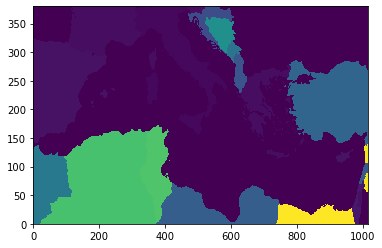

In [34]:
plt.figure()
plt.pcolormesh(mpw_mat)

In [48]:
data_popden = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Mikael/Input/gpw_v4_e_atotpopbt_dens_2pt5_min.nc')
pop_density = data_popden['Population Density, v4.10 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'][4,:,:]
X_pop,Y_pop = np.meshgrid(pop_density['longitude'],pop_density['latitude'])
pop_density_i = griddata((X_pop.ravel(),Y_pop.ravel()),pop_density.values.ravel(),(fieldMesh_x,fieldMesh_y),method='nearest')
dlon = lons[1]-lons[0]
dlat = lats[1]-lats[0]
grid_area = ((dlon*1.11e2) * (dlat*1.11e2)) * np.ones(fieldMesh_x.shape) * np.cos(fieldMesh_y * (np.pi/180))

#           kg/pop/day    pop/km2         km2 -> kg/day per grid cell
MPW_density = mpw_mat * pop_density_i * grid_area


/tmp/ipykernel_1307165/1628390048.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(MPW_density))


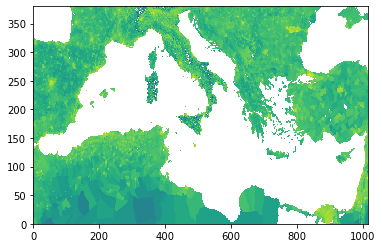

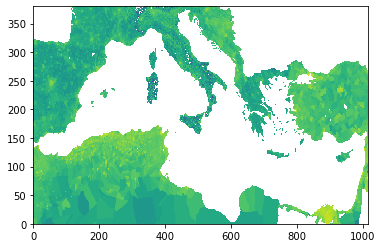

In [50]:
plt.figure()
plt.pcolormesh(np.log10(pop_density_i))

plt.figure()
plt.pcolormesh(np.log10(MPW_density))

In [58]:
from sea_clearly.create_masks import distance_to_shore

coastal_dist_land = distance_to_shore(~mask_land.astype(bool),dx=dlon*1.11e2)

6.540712775041246

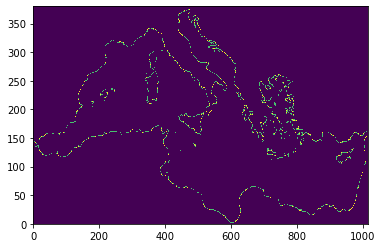

In [61]:
plt.pcolormesh(coastal_dist_land)
coastal_dist_land.max()

In [162]:

from sea_clearly.create_masks import get_coastal_nodes, get_coastal_nodes_diagonal
mask_land = mask_land.astype(bool)

mask_landborder = mask_land & (np.roll(~mask_land,1,axis=0) | np.roll(~mask_land,-1,axis=0) | 
                                       np.roll(~mask_land,1,axis=1) | np.roll(~mask_land,-1,axis=1))
mask_coast = ~mask_land & (np.roll(mask_land,1,axis=0) | np.roll(mask_land,-1,axis=0) | 
                                       np.roll(mask_land,1,axis=1) | np.roll(mask_land,-1,axis=1))



In [163]:
    n_iter = 20
    old_landborder = mask_coast.astype(bool).copy()
    current_landborder = mask_landborder.astype(bool).copy()

    # distance matrices in longitude (u) and latitude (v) directions,
    # and Euclidian distance matrix (total_distance)
    distance_u = np.zeros([len(lats),len(lons)])
    distance_v = np.zeros([len(lats),len(lons)])
    total_distance = np.zeros([len(lats),len(lons)])

    # distance at the coast is initialized to zero, other points are set to nan
    distance_u[:] = np.nan
    distance_v[:] = np.nan    
    total_distance[:] = np.nan
    distance_u[old_landborder] = 0.
    distance_v[old_landborder] = 0.
    total_distance[old_landborder] = 0.

    # for each cell on the land, we want to know what is the closest point to the coast.
    # we therefore keep track how many steps left/right, up/down we need to go
    index_closest_u = np.zeros([len(lats),len(lons)],dtype=int)
    index_closest_v = np.zeros([len(lats),len(lons)],dtype=int)

    for i1 in range(n_iter): 
        print(i1)
        #check which of the neighboring cells has the shortest distance (dist_new_x_u, dist_new_x_v arrays)
        # and save the relative position of the coastal point (index_new_x_u, index_new_x_v)

        # left, old distance, update
        dist_old_left_u = np.roll(distance_u,1,axis=1)   
        dist_old_left_v = np.roll(distance_v,1,axis=1)   
        dist_new_left_u = dist_old_left_u + (dlon*1.11e2 * np.cos(fieldMesh_y * (np.pi/180) ) )
        dist_new_left_v = dist_old_left_v
        dist_new_left = np.sqrt(dist_new_left_u **2 + dist_new_left_v**2)[current_landborder]
        index_new_left_u = np.roll(index_closest_u,1,axis=1) -1
        index_new_left_v = np.roll(index_closest_v,1,axis=1) 

        # right, old distance, update
        dist_old_right_u = np.roll(distance_u,-1,axis=1)   
        dist_old_right_v = np.roll(distance_v,-1,axis=1)   
        dist_new_right_u = dist_old_right_u + (dlon*1.11e2 * np.cos(fieldMesh_y * (np.pi/180) ) )
        dist_new_right_v = dist_old_right_v
        dist_new_right = np.sqrt(dist_new_right_u **2 + dist_new_right_v**2)[current_landborder]
        index_new_right_u = np.roll(index_closest_u,-1,axis=1) +1
        index_new_right_v = np.roll(index_closest_v,-1,axis=1) 

        # lower, old distance, update
        dist_old_lower_u = np.roll(distance_u,1,axis=0)   
        dist_old_lower_v = np.roll(distance_v,1,axis=0)   
        dist_new_lower_u = dist_old_lower_u 
        dist_new_lower_v = dist_old_lower_v + dlat*1.11e2
        dist_new_lower = np.sqrt(dist_new_lower_u **2 + dist_new_lower_v**2)[current_landborder]
        index_new_lower_u = np.roll(index_closest_u,1,axis=0) 
        index_new_lower_v = np.roll(index_closest_v,1,axis=0) -1 

        # upper, old distance, update
        dist_old_upper_u = np.roll(distance_u,-1,axis=0)   
        dist_old_upper_v = np.roll(distance_v,-1,axis=0)   
        dist_new_upper_u = dist_old_upper_u 
        dist_new_upper_v = dist_old_upper_v + dlat*1.11e2
        dist_new_upper = np.sqrt(dist_new_upper_u **2 + dist_new_upper_v**2)[current_landborder]
        index_new_upper_u = np.roll(index_closest_u,-1,axis=0) 
        index_new_upper_v = np.roll(index_closest_v,-1,axis=0) +1 

        # which cell (left/right/lower/upper) adjacent to the current landborder had the min. distance to the coast?   
        # 0=left, 1=right, 2=lower, 3=upper
        i_min_dist = np.nanargmin([dist_new_left,dist_new_right,dist_new_lower,dist_new_upper],axis=0)

        # put the new u/v distances in an array        
        newvals_u = np.zeros(len(i_min_dist))
        newvals_v = np.zeros(len(i_min_dist))
        newvals_u[i_min_dist == 0] = dist_new_left_u[current_landborder][i_min_dist == 0]
        newvals_v[i_min_dist == 0] = dist_new_left_v[current_landborder][i_min_dist == 0]

        newvals_u[i_min_dist == 1] = dist_new_right_u[current_landborder][i_min_dist == 1]
        newvals_v[i_min_dist == 1] = dist_new_right_v[current_landborder][i_min_dist == 1]

        newvals_u[i_min_dist == 2] = dist_new_lower_u[current_landborder][i_min_dist == 2]
        newvals_v[i_min_dist == 2] = dist_new_lower_v[current_landborder][i_min_dist == 2]

        newvals_u[i_min_dist == 3] = dist_new_upper_u[current_landborder][i_min_dist == 3]
        newvals_v[i_min_dist == 3] = dist_new_upper_v[current_landborder][i_min_dist == 3]

        #put the new distances in the distance matrix
        distance_u[current_landborder] = newvals_u
        distance_v[current_landborder] = newvals_v

        total_distance[current_landborder] = np.sqrt(distance_u**2 + distance_v**2)[current_landborder]

        # do the same tricks for the closest coastal index        
        newvals_index_u = np.zeros(len(i_min_dist))
        newvals_index_v = np.zeros(len(i_min_dist))
        newvals_index_u[i_min_dist == 0] = index_new_left_u[current_landborder][i_min_dist == 0]
        newvals_index_v[i_min_dist == 0] = index_new_left_v[current_landborder][i_min_dist == 0]

        newvals_index_u[i_min_dist == 1] = index_new_right_u[current_landborder][i_min_dist == 1]
        newvals_index_v[i_min_dist == 1] = index_new_right_v[current_landborder][i_min_dist == 1]

        newvals_index_u[i_min_dist == 2] = index_new_lower_u[current_landborder][i_min_dist == 2]
        newvals_index_v[i_min_dist == 2] = index_new_lower_v[current_landborder][i_min_dist == 2]

        newvals_index_u[i_min_dist == 3] = index_new_upper_u[current_landborder][i_min_dist == 3]
        newvals_index_v[i_min_dist == 3] = index_new_upper_v[current_landborder][i_min_dist == 3]

        index_closest_u[current_landborder] = newvals_index_u
        index_closest_v[current_landborder] = newvals_index_v

        # update the landborder for the next iteration
        current_landborder = (mask_land 
                              & (np.roll(current_landborder,1,axis=0) | np.roll(current_landborder,-1,axis=0) | 
                                               np.roll(current_landborder,1,axis=1) | np.roll(current_landborder,-1,axis=1))
                              & ~current_landborder).astype(bool)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

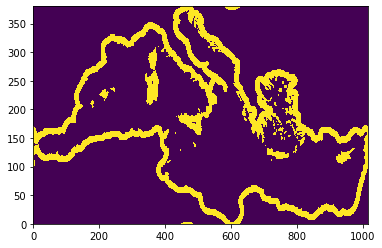

In [164]:
np.nanmax(total_distance)
plt.pcolormesh(total_distance<50)
np.nanmax(total_distance)

mask_50km = ((total_distance < 50) & mask_land).astype(bool)
mask_50km

In [165]:
index_mat_u,index_mat_v = np.meshgrid(np.arange(len(lons),dtype=float),np.arange(len(lats),dtype=float))

index_mat_u[mask_50km] += index_closest_u[mask_50km]
index_mat_v[mask_50km] += index_closest_v[mask_50km]
index_mat_u = (index_mat_u % len(lons)) 
index_mat_v = (index_mat_v % len(lats))

index_array_closest_u = index_mat_u[mask_50km].astype(int)
index_array_closest_v = index_mat_v[mask_50km].astype(int)

input_matrix = np.zeros([fieldMesh_x.shape[0],fieldMesh_x.shape[1]])
np.add.at(input_matrix,(index_array_closest_v,index_array_closest_u),MPW_density[mask_50km])

/tmp/ipykernel_1307165/3592501505.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(input_matrix))


array([-6.       , -5.9583335, -5.9166665, ..., 36.208332 , 36.25     ,
       36.291668 ], dtype=float32)

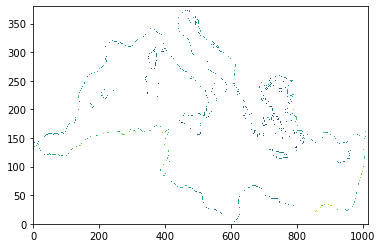

In [170]:
plt.pcolormesh(np.log10(input_matrix))
lons

In [171]:
from sea_clearly.write_tools import to_netcdf
to_netcdf('../data/coastal_MPW_input.nc',[input_matrix],['MPW'],lons,lats,explanation='MPW input in kg/day from 50km radius')

/tmp/ipykernel_1307165/1839449158.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(MPW_density_50km))


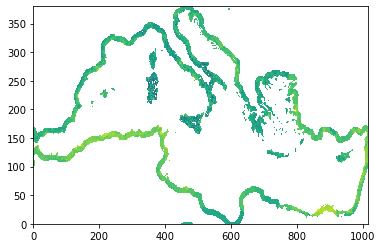

In [145]:
# plt.pcolormesh(MPW_density[mask_50km])
MPW_density_50km = MPW_density.copy()
MPW_density_50km[~mask_50km.astype(bool)] = 0

plt.pcolormesh(np.log10(MPW_density_50km))


In [147]:
mask_50km.astype(bool).sum()

47417